# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import NCFDataset
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from tuner import NCFTuner
from helpers.splitter import Splitter
import ast
from helpers.get_feature_dims import get_feature_dims

# Loading data

In [2]:
metadata_features = ['tags', 'publishers', 'z_released_date']

In [3]:
df = pd.read_csv('../data/interaction-metadata.csv')[['user_id', 'item_id', 'rating_imp', 'timestamp'] + metadata_features]
df.head()

,user_id,item_id,rating_imp,timestamp,tags,publishers,z_released_date
0,76561197960432447,10,1,1738278781,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",['Valve'],-6.491067
1,76561198071230926,10,1,1736206418,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",['Valve'],-6.491067
2,76561198206216352,10,1,1738041574,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",['Valve'],-6.491067
3,76561198110801124,10,1,1738015332,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",['Valve'],-6.491067
4,76561199813732773,10,1,1737853720,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",['Valve'],-6.491067


In [4]:
df['publishers'] = df['publishers'].apply(ast.literal_eval)
df['tags'] = df['tags'].apply(ast.literal_eval)

# Indexing data

In [5]:
index_manager = IndexManager()
index_manager.fit(df_interaction=df)
index_manager.transform(df, inplace=True)

Indexed 832660 users and 68396 items
User index range: 0-832659
Item index range: 0-68395


,user_id,item_id,rating_imp,timestamp,tags,publishers,z_released_date
0,0,0,1,1738278781,"[Action, FPS, Multiplayer, Shooter, Classic, T...",[Valve],-6.491067
1,1,0,1,1736206418,"[Action, FPS, Multiplayer, Shooter, Classic, T...",[Valve],-6.491067
2,2,0,1,1738041574,"[Action, FPS, Multiplayer, Shooter, Classic, T...",[Valve],-6.491067
3,3,0,1,1738015332,"[Action, FPS, Multiplayer, Shooter, Classic, T...",[Valve],-6.491067
4,4,0,1,1737853720,"[Action, FPS, Multiplayer, Shooter, Classic, T...",[Valve],-6.491067
...,...,...,...,...,...,...,...
1149950,15755,24642,1,1663545142,"[Indie, Casual, Adventure]",[FlairBot Games],-0.582531
1149951,150280,24642,1,1689826252,"[Indie, Casual, Adventure]",[FlairBot Games],-0.582531
1149952,1336,24643,1,1595699739,"[Action, Indie, Casual, Platformer, Precision ...",[PsychoFlux Entertainment],-0.457079
1149953,11520,24643,0,1706470035,"[Action, Indie, Casual, Platformer, Precision ...",[PsychoFlux Entertainment],-0.457079


# Splitting data

In [6]:
splitter = Splitter(df)
df_train, df_val, df_test = splitter.leave_k_out_split()

Splitting data with leave-2-out strategy (1 for validation, 1 for testing)
Total users: 832660
Interactions per user: min=1, max=1034, avg=1.4
Note: 703199 users have fewer than 2 interactions.
These users will be placed entirely in the training set.
Split complete: 1149955 total interactions
Train set: 891033 interactions (77.5%)
Validation set: 129461 interactions (11.3%)
Test set: 129461 interactions (11.3%)


# Tuning model

In [7]:
feature_dims = get_feature_dims(df, metadata_features, [8, 16, 32, 64])
df_features = df[['item_id'] + metadata_features].drop_duplicates(subset='item_id')

unique_users = index_manager.get_indexed_users()
unique_items = index_manager.get_indexed_items()

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
    feature_dims=feature_dims,
    df_features=df_features,
)

In [8]:
param_grid = {
            'factors': [8, 16, 32, 64],
            'mlp_user_item_dim': [32, 64, 128],
            'learning_rate': [0.0005, 0.001],
            'epochs': [200],
            'optimizer': ['adagrad', 'adam', 'sgd'],
            'dropout': [0.0, 0.2, 0.5],
            'weight_decay': [0.0, 0.00001, 0.0001, 0.001],
            'loss_fn': ['bce', 'mse', 'bpr'],
            'batch_size': [4096, 8192, 16384],
}

tuner.set_param_grid(param_grid)

In [10]:
results, file_path = tuner.perform_random_search(num_trials=1)

Running experiment with params: {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.001, 'epochs': 200, 'optimizer': 'adam', 'dropout': 0.2, 'weight_decay': 1e-05, 'loss_fn': 'bpr', 'batch_size': 8192, 'mlp_feature_dims': {'publishers': (36059, 16)}}
Epoch 1/200


ValueError: too many dimensions 'str'

In [8]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 32, 'mlp_user_item_dim': 32, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 16384}, 'value': 0.03285981652502071}, 'NDCG@10': {'params': {'factors': 32, 'mlp_user_item_dim': 32, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 16384}, 'value': 0.016618273490809826}, 'Recall@10': {'params': {'factors': 32, 'mlp_user_item_dim': 32, 'mlp_time_dim': 8, 'learning_rate': 0.0005, 'epochs': 100, 'optimizer': 'adagrad', 'dropout': 0.2, 'weight_decay': 0.0, 'loss_fn': 'bpr', 'batch_size': 16384}, 'value': 0.03285981652502071}}


# Analyzing results

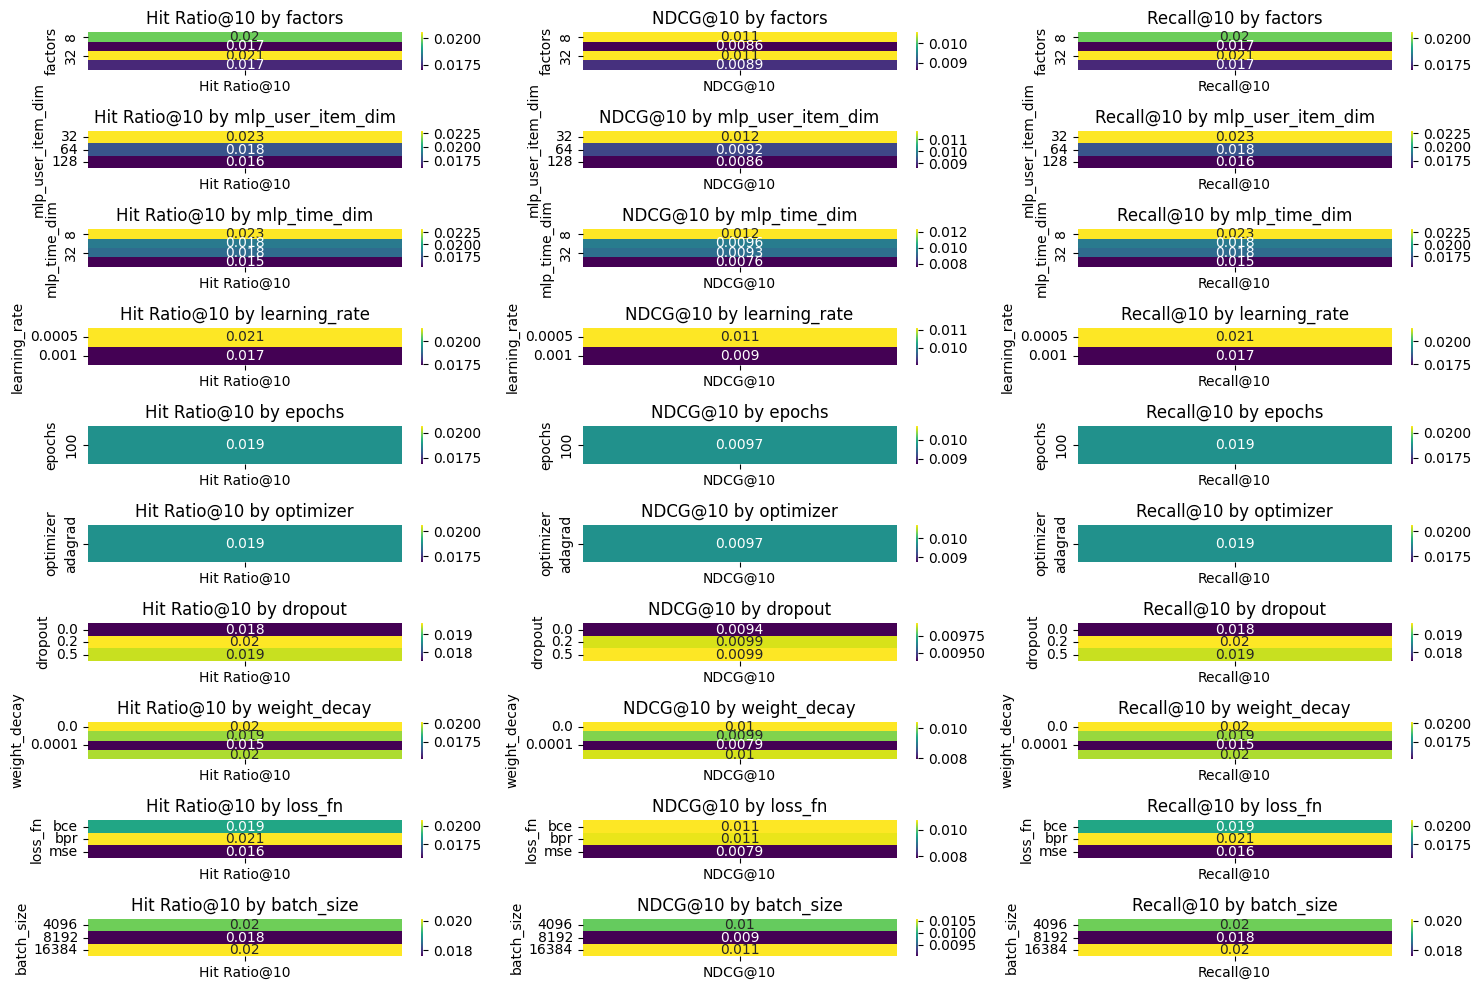

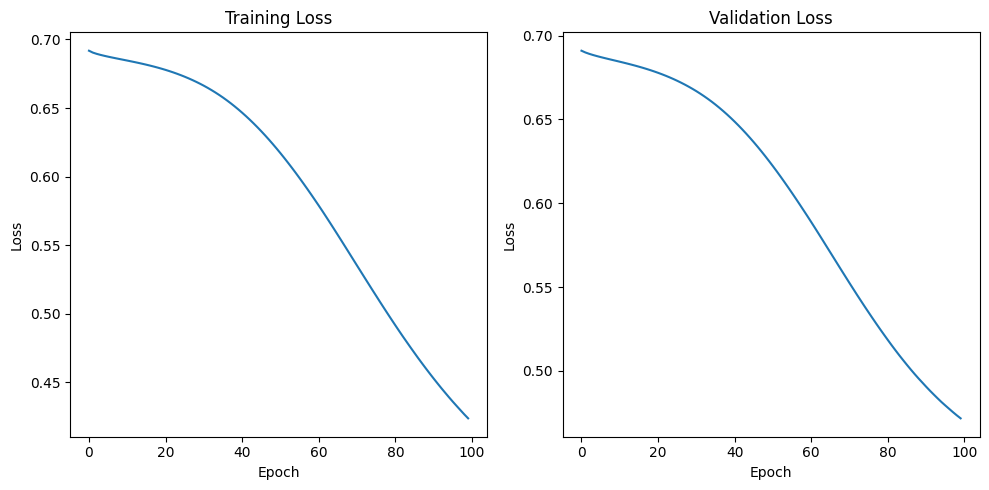

In [9]:
df_result = tuner.plot_results()

In [26]:
df_result

,factors,mlp_user_item_dim,mlp_time_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,Hit Ratio@10,NDCG@10,Recall@10
0,64,64,64,0.0010,100,adagrad,0.0,0.00100,mse,4096,0.013446,0.007307,0.013446
1,32,32,8,0.0005,100,adagrad,0.2,0.00000,bpr,16384,0.032860,0.016618,0.032860
2,64,128,16,0.0005,100,adagrad,0.5,0.00000,bce,16384,0.018018,0.010896,0.018018
3,32,32,16,0.0010,100,adagrad,0.5,0.00001,bpr,4096,0.021178,0.010430,0.021178
4,8,128,16,0.0005,100,adagrad,0.2,0.00100,bpr,8192,0.019567,0.010120,0.019567
5,8,32,16,0.0010,100,adagrad,0.5,0.00001,bpr,4096,0.021799,0.011973,0.021799
6,16,64,32,0.0010,100,adagrad,0.5,0.00001,mse,4096,0.019644,0.009444,0.019644
7,16,64,64,0.0010,100,adagrad,0.2,0.00010,bpr,8192,0.015448,0.007784,0.015448
8,16,64,16,0.0010,100,adagrad,0.5,0.00000,bpr,8192,0.019836,0.010011,0.019836
9,8,32,64,0.0005,100,adagrad,0.5,0.00000,mse,16384,0.018961,0.009058,0.018961


# Train model with best params

In [ ]:
best_param = best_params['Hit Ratio@10']['params']
batch_size = best_param.pop('batch_size')
mlp_feature_dims = best_param.pop('mlp_feature_dims')

In [11]:
dataset_params = {
    'df_features': df_features,
    'feature_dims': mlp_feature_dims,
}

train_dataset = NCFDataset(df_train, **dataset_params)
val_dataset = NCFDataset(df_val, **dataset_params)

dataloader_params = {
    'batch_size': batch_size,
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 4,
    'pin_memory': True,
}

train_dataloader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
val_dataloader = DataLoader(val_dataset, shuffle=False, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, mlp_feature_dims=mlp_feature_dims, df_features=df_features, **best_param)
model.fit(train_dataloader, val_dataloader)

All weights initialized with Gaussian distribution (mean=0, std=0.01)
Epoch 1/100
Train loss: 0.879244, Validation loss: 0.871394
Epoch 2/100
Train loss: 0.878624, Validation loss: 0.870917
Epoch 3/100
Train loss: 0.878197, Validation loss: 0.870538
Epoch 4/100
Train loss: 0.877826, Validation loss: 0.870228
Epoch 5/100
Train loss: 0.877545, Validation loss: 0.869922
Epoch 6/100
Train loss: 0.877198, Validation loss: 0.869611
Epoch 7/100
Train loss: 0.876895, Validation loss: 0.869299
Epoch 8/100
Train loss: 0.876587, Validation loss: 0.869004
Epoch 9/100
Train loss: 0.876259, Validation loss: 0.868668
Epoch 10/100
Train loss: 0.875908, Validation loss: 0.868297
Epoch 11/100
Train loss: 0.875486, Validation loss: 0.867874
Epoch 12/100
Train loss: 0.874988, Validation loss: 0.867363
Epoch 13/100
Train loss: 0.874423, Validation loss: 0.866805
Epoch 14/100
Train loss: 0.873795, Validation loss: 0.866156
Epoch 15/100
Train loss: 0.873041, Validation loss: 0.865370
Epoch 16/100
Train loss:

In [12]:
evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Starting evaluation preparation...
Creating ground truth sets...
Ground truth created for 130372 users with an average of 1.0 items each
Ground truth creation completed in 2.29 seconds
Extracting timestamps for each user...
Timestamp extraction completed in 0.12 seconds
Generating predictions for 130372 users...
Processing predictions for 130372 users and 69001 items
Processing 1 of 130372 users... (0.00%)
Memory usage: 0.141845703125 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 128 to 141
Increased item batch size from 1024 to 1126
Processing 129 of 130372 users... (0.10%)
Memory usage: 0.093505859375 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 141 to 155
Increased item batch size from 1126 to 1239
Processing 270 of 130372 users... (0.21%)
Memory usage: 0.097900390625 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 155 to 170
Increased item batch size from 1239 to 1363
Proce

In [13]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0425782
NDCG@10:	 0.0197211
Recall@10:	 0.0425782


# Interpreting predictions

In [14]:
df_interaction_count = df.groupby('user_id')[['item_id']].nunique().sort_values('item_id', ascending=False)

In [15]:
df_interaction_count[df_interaction_count['item_id'] == 10]

,item_id
user_id,
141666,10
158712,10
50193,10
255627,10
52048,10
...,...
118056,10
356725,10
17134,10


In [16]:
user_id = 141666

In [17]:
df[df['user_id'] == user_id]

,user_id,item_id,rating_imp,timestamp,z_timestamp
158130,141666,33017,0,1641471440,-0.570794
168364,141666,33789,0,1612374138,-0.910569
324424,141666,45795,1,1704051359,0.159966
384844,141666,50159,0,1703965957,0.158968
699841,141666,3261,0,1412768342,-3.241410
963573,141666,12581,0,1700307490,0.116248
986333,141666,13777,1,1672305769,-0.210735
1012781,141666,15355,1,1610746559,-0.929575
1028380,141666,16342,0,1690715633,0.004241
1110849,141666,21866,1,1672441918,-0.209145


In [18]:
predictions = model.batch_predict_for_users([user_id], [1704051359])

Processing predictions for 1 users and 69001 items
Processing 1 of 1 users... (0.00%)
Memory usage: 0.0859375 . Increasing batch size with increasing rate of 1.1
Increased user batch size from 1024 to 1126
Increased item batch size from 8096 to 8906
Prediction completed in 0.24 seconds


In [19]:
predictions

{141666: [23003,
  23005,
  23010,
  22997,
  23002,
  23001,
  23000,
  22999,
  22998,
  69000]}

## User actual items

In [21]:
user_actual_items = df[(df['user_id'] == user_id)]['item_id'].values
user_actual_items = [index_manager.item_idx_to_id[item] for item in user_actual_items]
user_actual_items

[1281200,
 1309700,
 1796130,
 1982630,
 302910,
 586130,
 624330,
 676730,
 706690,
 886610]

In [22]:
df[df['item_id'].isin(user_actual_items)][['name', 'item_id', 'publishers', 'tags']]

,name,item_id,publishers,genres,tags
8874,The Mystery of Happyville,886610,['Studio HK'],"['Violent', 'Gore', 'Action', 'Adventure', 'Ca...","['Action', 'Adventure', 'Indie', 'Casual', 'Go..."
15846,Megatronic Void,706690,['Conglomerate 5'],"['Action', 'Indie']","['Action', 'Indie', 'Platformer', 'Adventure',..."
17043,Behind The Door,676730,['Dio Alias Games'],"['Adventure', 'Indie']","['Indie', 'Adventure', 'Puzzle', 'Horror', 'Po..."
22917,Exorcism Ritual,1982630,['Antitesa'],"['Action', 'Indie']","['Action', 'Puzzle', 'Shooter', 'FPS', 'Realis..."
23322,Devil's dream,1309700,['Milkoi Games'],['Indie'],"['Indie', 'First-Person', 'Horror', 'Survival ..."
32469,The Walking Fish 2: Final Frontier,1281200,"['That Fish', 'That Other Fish']","['Adventure', 'Indie']","['Adventure', 'Indie', 'Horror', 'Surreal', 'C..."
41865,The House,302910,['Konsordo'],"['Action', 'Adventure', 'Indie']","['Horror', 'Indie', 'Action', 'Adventure', 'Wa..."
70976,Survival Driver,586130,['HaDe Games'],"['Casual', 'Indie', 'Racing']","['Indie', 'Racing', 'Casual']"
85275,Scare: Project of Fear,1796130,['HV'],"['Action', 'Adventure', 'Indie', 'Simulation']","['Survival Horror', 'Psychological Horror', 'S..."


## Predicted items

In [23]:
predictions = [index_manager.item_idx_to_id[item] for item in predictions[user_id]]
predictions

[929460,
 929510,
 929640,
 929320,
 929440,
 929430,
 929420,
 929410,
 929400,
 3467390]

In [24]:
df_prediction = df[df['item_id'].isin(predictions)][['name', 'item_id', 'publishers', 'tags']]
df_prediction

,name,item_id,publishers,genres,tags
7365,Money Master,929460,['Happy Home Company'],"['Casual', 'Simulation']","['Casual', 'Simulation', 'Board Game']"
7368,Type Fighter,929510,['Simon Harvey'],['Action'],"['Action', 'Pixel Graphics', 'Typing', 'Casual..."
7373,Farragnarok,929640,['Farrago Fiction'],"['Casual', 'Simulation', 'Early Access']","['Early Access', 'Casual', 'Simulation']"
7392,RHEM II SE: The Cave,929320,['Runesoft GmbH'],['Adventure'],"['Adventure', 'Point & Click', 'Singleplayer',..."
7394,Mahjong Magic Journey 3,929400,['8floor'],['Casual'],"['Casual', 'Mahjong', 'Puzzle', 'Board Game', ..."
7395,Christmas Mahjong 2,929410,['8floor'],['Casual'],"['Casual', 'Mahjong', 'Puzzle', 'Board Game', ..."
7396,Sakura Day 2 Mahjong,929420,['8floor'],['Casual'],"['Casual', 'Puzzle', 'Mahjong', 'Board Game', ..."
7397,Mahjong Magic Journey 2,929430,['8floor'],['Casual'],"['Casual', 'Mahjong', 'Puzzle', 'Board Game', ..."
7398,Christmas Mahjong,929440,['8floor'],['Casual'],"['Casual', 'Mahjong', 'Puzzle', 'Romance', 'Nu..."
81705,DON'T GET GOT,3467390,['CULT Games'],"['Action', 'Early Access']","['Early Access', 'Horror', 'Multiplayer', 'Onl..."


In [25]:
# import webbrowser
# base_url = 'https://store.steampowered.com/agecheck/app/'
#
# item_ids = df_prediction['item_id'].values
# for item_id in item_ids:
#     webbrowser.open(f'{base_url}{item_id}')